# Teaching model: Positive examples only
Natalia Vélez, November 2020

In [23]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from tqdm import notebook

sns.set_style('white')
sns.set_context('talk')

## Set up problem

Manually define alternatives in problem space:

In [2]:
empty_square = [
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0]
]

squareA = [
     [0,0,0,0,0,0],
     [0,1,1,1,1,0],
     [0,1,1,1,1,0],
     [0,1,1,1,1,0],
     [0,1,1,1,1,0],
     [0,0,0,0,0,0]
]

squareB = [
     [0,0,0,0,0,0],
     [0,1,0,0,0,0],
     [0,1,1,0,0,0],
     [0,1,1,1,0,0],
     [0,1,1,1,1,0],
     [0,0,0,0,0,0]
]

squareC = [
     [0,0,0,0,0,0],
     [0,1,1,1,1,0],
     [0,0,1,1,1,0],
     [0,0,0,1,1,0],
     [0,0,0,0,1,0],
     [0,0,0,0,0,0]
]

squareD = [
     [0,0,0,0,0,0],
     [0,0,1,1,0,0],
     [0,1,1,1,1,0],
     [0,1,1,1,1,0],
     [0,0,1,1,0,0],
     [0,0,0,0,0,0]
]

example_problem = np.array([squareA, squareB, squareC, squareD])
print(example_problem.shape)

(4, 6, 6)


Plot problems:

In [3]:
def plot_problem(problem):
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    opt_labels = 'ABCD'

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='gray_r', cbar=False,
                         linewidths=2, linecolor='#808080')
        ax_i.set(xticks=[], yticks=[], title=opt_labels[idx])     

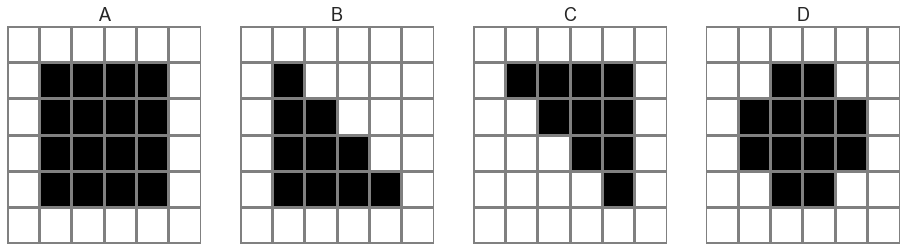

In [4]:
plot_problem(example_problem)

Plot what examples look like to the learner: 

In [5]:
def plot_example(ex, ax=None):
    example = np.ones((6,6))*0.5
    example.flat[list(ex)] = 1
    #example = example.filled(0.5)
    ax = sns.heatmap(example, vmin=0, vmax=1, 
                     cmap='gray_r', cbar=False, square = True,
                     linewidths=1, linecolor='#808080', ax=ax)
    ax.set(xticks=[],yticks=[])

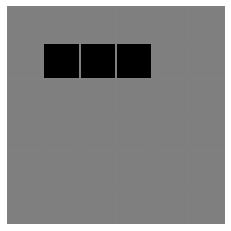

In [6]:
plot_example((7,8,9))

## Select examples to teach

Get all possible positive examples for a concept

In [7]:
def get_pos_idx(concept):
    pos_coords = np.nonzero(concept)
    pos_idx = np.ravel_multi_index(pos_coords, (6,6))

    return list(pos_idx)

Get all combinations of n examples:

In [8]:
def is_increasing(l): return all(l[i] < l[i+1] for i in range(len(l) - 1))
def n_examples(examples, n):
    all_examples = list(product(*([examples] * n)))
    valid_examples = [e for e in all_examples if is_increasing(e)]
    
    return valid_examples

Check if a concept is consistent with presented examples;

In [9]:
def is_valid(concept, example):
    # What does the learner's screen look like?
    mask = np.ones((6,6))
    mask.flat[list(example)] = 0
    mask = mask.astype(np.bool)
    revealed = np.ma.masked_array(np.ones((6,6)), mask=mask)

    # Does it match the concept?
    return all(revealed[~mask] == concept[~mask])

Check all concepts in a teaching problem:

In [10]:
def all_valid(problem, example):
    n_problems = problem.shape[0]
    valid = [is_valid(problem[i,:,:], example) for i in range(n_problems)]
    return valid

In [11]:
all_valid(example_problem, [7,8,9])

[True, False, True, False]

## Teacher-learner model

### Learner 0

In [12]:
def learner0(problem, example):
    valid = all_valid(problem, example)
    n_valid = np.sum(valid)
    p_h = valid/n_valid
    
    return p_h

In [13]:
learner0(example_problem, [7,8,9])

array([0.5, 0. , 0.5, 0. ])

### Teacher 0

In [18]:
def teacher0(problem,n,h):
    # Get all possible positive examples for a concept
    concept = problem[h,:,:]
    pos_idx = get_pos_idx(concept)
    examples = n_examples(pos_idx, n)

    # Select examples, given learner's belief in true hypothesis
    p_h = np.array([learner0(problem, e) for e in examples])
    d_h = p_h[:,h]/np.sum(p_h[:,h])

    return d_h,examples

### Learner 1

In [19]:
def learner1(problem, example):
    prior = learner0(problem, example) 
    h_d = []
    for h in range(problem.shape[0]):
        if prior[h] > 0:
            d_h,all_examples = teacher0(problem, len(example), h)
            ex_idx = all_examples.index(example)
            h_d.append(d_h[ex_idx])
        else:
            h_d.append(0)

    h_d = np.array(h_d)
    h_d = h_d/np.sum(h_d)
    
    return h_d

### Teacher 1

In [36]:
def teacher1(problem,n,h):
    # Get all possible positive examples for a concept
    concept = problem[h,:,:]
    pos_idx = get_pos_idx(concept)
    examples = n_examples(pos_idx, n)

    # Select examples, given learner's belief in true hypothesis
    h_d = []
    for e in notebook.tqdm(examples):
        h_d.append(learner1(problem, e))
    h_d = np.array(h_d)
    print(h_d.shape)
    d_h = h_d[:,h]/np.sum(h_d[:,h])

    return d_h,examples

In [41]:
d_h, examples =teacher1(example_problem,3,3)


(220, 4)


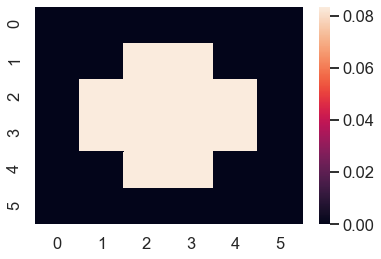

In [57]:
flat_examples = [item for sublist in examples for item in sublist]
idx, freq = np.unique(flat_examples, return_counts = True)
freq = freq/np.sum(freq)
freq_array = np.zeros((6,6))
freq_array.flat[idx] = freq
sns.heatmap(freq_array)

In [56]:
freq

array([0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333, 0.08333333])

### Learner 2